# COVID-19: BERT-based STS Method to Effectively Identify Articles related to Therapeutics and Vaccines

* #### Team: MD-Lab, ASU
* #### Author: Mihir Parmar
* #### Team Members: Rishab Banerjee, Hong Guan, Jitesh Pabla, Ashwin Karthik Ambalavanan, Murthy Devarakonda
* #### Email ID: loccapollo@gmail.com, hguan6@asu.edu, jpabla1@asu.edu, aambalav@asu.edu, Murthy.Devarakonda@asu.edu
* #### Kaggle ID: loccapollo, hongguan, jiteshpabla, aambalav, murthydevarakonda
* #### This is a Team Submission

### On March 19, 2020, the White House Office of Science and Technology Policy (WH-OSTP) issued a statement announcing the release of an extensive machine-readable collection of scientific articles about COVID-19, SARS-CoV-2, and the coronavirus group, jointly by several institutions including National Library of Medicine and Allen Institute for AI, and WH-OSTP: 
> the institutions in issuing a call to action to the Nation’s artificial intelligence experts to develop new text and data mining techniques that can help the science community answer high-priority scientific questions related to COVID-19
### The dataset called COVID-19 Open Research Dataset (CORD-19) presently has nearly 59,000 articles (extracted from various archives), with more than 35,000 of which have full text. The institutions further compiled a series of questions to be answered. For example, some questions related to COVID-19 vaccines and therapeutics are:
* Effectiveness of drugs being developed and tried to treat COVID-19 patients.
* Exploration of use of best animal models and their predictive value for a human vaccine.
* Efforts targeted at a universal coronavirus vaccine.
* Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers

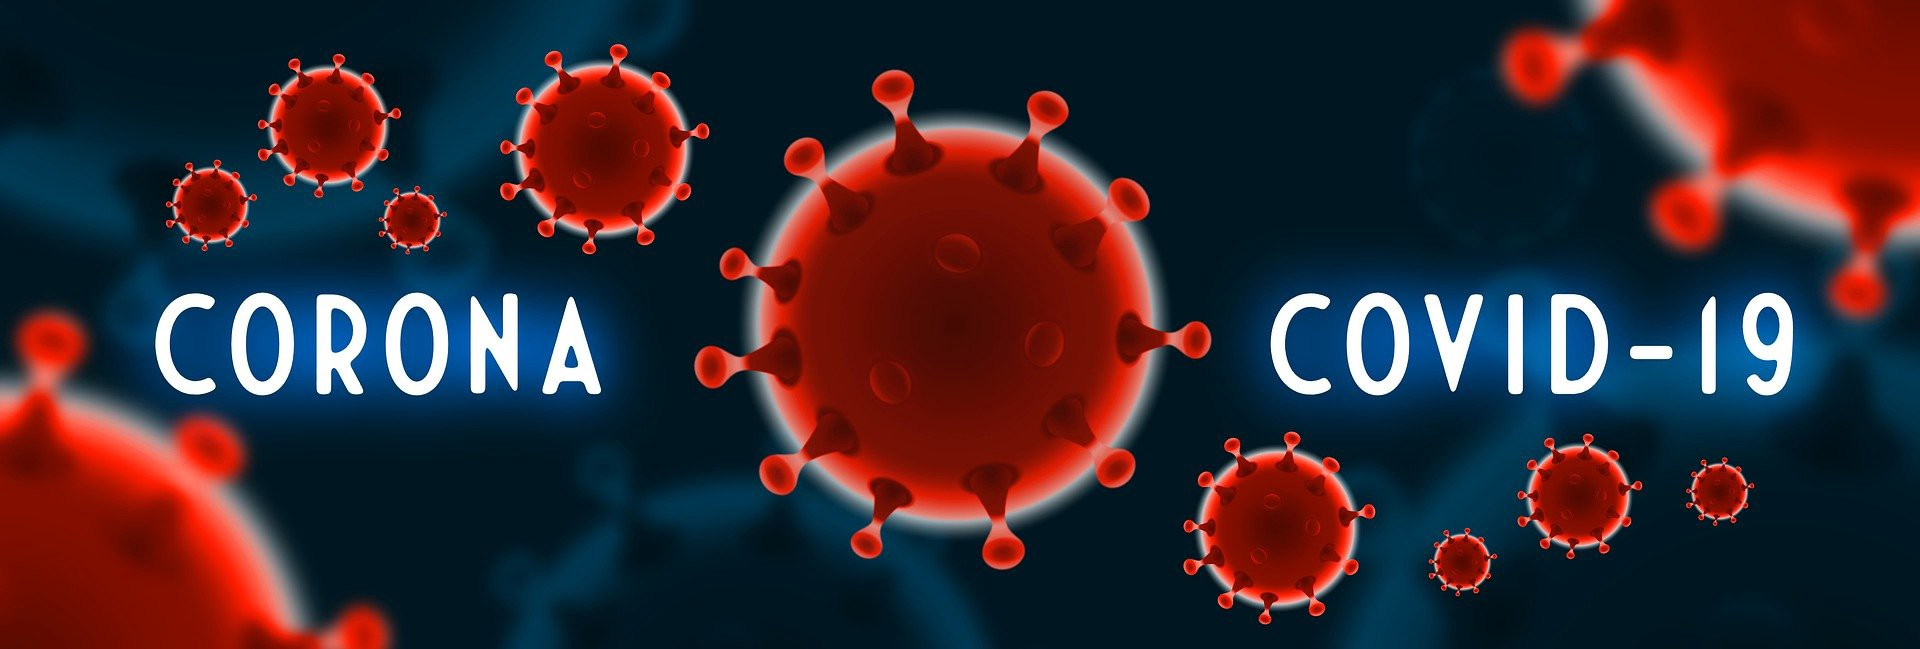

# Project Description

The objective of this project is to use the state-of-the-art Clinical Semantic Textual Similarity (STS) technique to create a method to search an answer for the given query through the dataset of research papers provided as a part of [Kaggle's competition CORD-19-research-challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Currently, we are considering a limited amount of given text (Titles + Abstracts + Journals) for each paper to show the effectiveness of the proposed approach. Gradually, this project could be extended into a scientific search system where you can extract machine-readable scientific data for a given query for further analysis.

# Proposed Methodology

Neural Networks have become more popular in the domain of information retrieval. As we know, BERT-based scoring systems outperform previous approaches to the document retrieval as shown in [Yang et al. 2019](https://www.aclweb.org/anthology/D19-3004.pdf). Here, we are using Clinical Semantic Textual Similarity (STS)-based novel approach for document scoring. The primary aim of this method is to find documents that are most relevant to the given query. Here, we have used the Clinical STS dataset from [n2c2 Challange 2019](https://n2c2.dbmi.hms.harvard.edu/) to fine-tune the BERT model. As illustrated in below figure (a), we have used BERT model for Next Sentence Prediction, and feed pair of sentences together ([CLS]Sentence 1[SEP]Sentence 2) to the BERT at training time, and used CLS token embedding for predicting similarity score between two sentences. The core idea behind using this model is that we want to generate embedding which contains the relevance between sentence 1 and sentence 2. Here, we have used Linear Regression (LR) as a regression model. The dataset consists of two sentences and their clinical semantic similarity score ranging from 0 to 5.0. The following is an example of a data item from the dataset. As can be seen from the example, the two sentences are to be scored on their semantic similarity.

Sentence 1: Neuro:  Proximal and distal strength in the upper and lower extremities is grossly intact.	
Sentence 2: The distal circulation, sensation, and motor function is intact.	
Similarity score: 2.5/5.0

BERT with linear regression on the top of the output CLS token is trained with the ClinicalSTS dataset. As a model input shown in figure (b), the query Q and the document text A are concatenated as a text sequence [[CLS] Q [SEP] A [SEP]], where document A = [title + abstract + journal], and passed through the trained BERT + linear regression to obtain a similarity score between Q and A. 

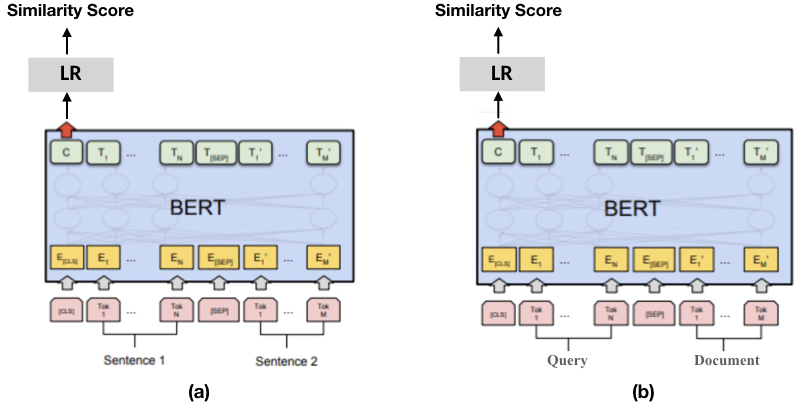

In this simple approach, long text poses a problem since base-BERT can handle only the 512 length of sentence at a time. In this case, we have research papers with full body text. Based on Yang et al. 2019, we presented sentence level inference as a solution to this problem. Hence, we generated the score for each sentence in the given document and aggregate that score to produce the document score. To get the score for the whole document, we simply devise function inspired by [Kotzias et al. 2015](https://dl.acm.org/doi/10.1145/2783258.2783380) that assumes that the score of a document is obtained by averaging the score of its top n sentences. Assume candidate document d and corresponding set of sentences $\mathcal{S}$ from d. Hence, document score ($S_d$) is given by below averaging formula:

$S_d = \frac{1}{|\mathcal{S}|} \sum_{i=0}^{n} \text{score}(s_i)$,

where $\text{score}(s_i)$ denoted the function which gererates similarity score corresponding to the given input. In this formula, we are only considering the top n sentences from given text with high scores because they are more responsible for identifying the text. At the end, we normalized the obtained score between [0,1].

## Scalability of Proposed Model

In this work, a limited amount of data (i.e., [title + abstract + journal]) is used to show the effectiveness of this given methodology. However, this model is easily scalable on the full-text of the given research article since it is using a sentence level inference for calculating the similarity score between the query and given article. You can see our interactive implementation of the proposed model and scale it as per your requirements.  

# Implementation

We present a notebook that makes it possible for anyone to reproduce our system or modify it according to their requirements. We made our fine-tuned BERT models available and code to use it. Our notebook is set up to allow similarity score to be calculated for given test set collection (i.e., set of research articles in this competition). Here, we fine-tuned the BERT base model with a learning rate $2 x 10^{-4}$ for 10 epochs.

For the implementation of the above approach, we have used [Pytorch](https://pytorch.org/) implementation of the BERT model by [huggingface](https://huggingface.co/transformers/index.html). All Code, Models, Data and Results mentioned in this Kernel are well documented and available in this [GitHub Link](https://github.com/md-labs/covid19-kaggle/tree/Mihir_3009/scripts).

In [ ]:
# importing important libraries for code

import csv
import os
import random
import sys

import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import unidecode
import re

import torch
import torch.nn as nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from torch.autograd import Variable
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm, trange
from scipy.stats.stats import pearsonr

from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertModel

In [ ]:
# Checking for GPU availability

device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
n_gpu = torch.cuda.device_count()
print("device: {} n_gpu: {}".format(device, n_gpu))

For the fine-tuning of the BERT, we used the Clinical STS dataset from [n2c2 Challange 2019](https://n2c2.dbmi.hms.harvard.edu/). This dataset is not publicly available. Hence, we haven't provided a code here for fine-tuning of the BERT, however, you can visit our [GitHub link](https://github.com/md-labs/covid19-kaggle/tree/Mihir_3009/scripts) for this script for fine-tuning and tried out some other scientific or clinical STS datasets. Here, the fine-tuned model of the BERT on the Clinical STS dataset is uploaded for further use. You can use the below code to use this fine-tuned model.

In [ ]:
# Use this class for linear regression model

class linearRegression(nn.Module):
    def __init__(self):
        super(linearRegression, self).__init__()
        self.linear = nn.Linear(768, 1)  # input and output is 1 dimension

    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
# Initializing the fine-tuned model

model_class= BertModel
model_dir= '../input/models/'

# Load a trained model and config that you have fine-tuned
tokenizer = BertTokenizer.from_pretrained('../input/tokenizer/bert-base-uncased-vocab.txt')
model = model_class.from_pretrained(model_dir)
regression = torch.load(join(model_dir,"regression_model.pth"), map_location=torch.device(device))
model.to(device)
regression.to(device)

# Initializing the parameters
max_seq_length= 128
batch_size=1

The main aim of this work is to provide a system that can give you documents that are relevant to the given query. Here, you can provide your custom query to get the desired output. This model uses several queries that are likely to be useful in searching for a vaccine and therapeutics related articles. The COVID-19 dataset challenge questions are leveraged for this purpose. Examples are:

* Q1: Vaccine vaccination dose antitoxin serum immunization inoculation for COVID-19 or coronavirus related research work
* Q2: Therapeutics treatment therapy drug antidotes cures remedies medication prophylactic restorative panacea for COVID-19 or coronavirus

We provided the model output in the result section.

In [ ]:
# You can update this query list for your desire output

query_list = ['vaccine vaccination dose antitoxin serum immunization inoculation for covid 19 or coronavirus related research work', 
              'therapeutics treatment therapy drug antidotes cures remedies medication prophylactic restorative panacea for covid 19 or coronavirus']

Below is the code for computing similarity score between the query and given scientific article. You can modify this code according to your requirements.

In [ ]:
#Initialize evaluation mode
model.eval()
regression.eval()

#Loading the test set given by this challange
test_path= '../input/CORD-19-research-challenge/metadata.csv'
df_test= pd.read_csv(test_path)

#Empty List for saving the final computated score
final_score= list()
query_number=1

# Loop that calculate score corresponding to each query given in above list
for query in query_list:
    for i in range(len(df_test)):
        
        # Aggregating the [title + abstract + journal]. You can modify it according to your input
        document= str(df_test.iloc[i].title) + str(df_test.iloc[i].abstract) + str(df_test.iloc[i].journal)
    
        iteration = int(len(document)/max_seq_length)
    
        if iteration==0:
            final_score.append(0)
            continue
    
        result= list()
        sentence= list()
        
        # Loop for create sentence inputs
        for i in range(0,iteration):
            sent= document[(i*max_seq_length):(i+1)*max_seq_length]
            sentence.append(sent)
        
        df_temp= pd.DataFrame(sentence, columns=['d_sent'])
        df_temp['q']= query
    
        # Create text sequence
        sentences_1 = df_temp.q
        sentences_2 = df_temp.d_sent
    
        # We need to add special tokens at the beginning and end of each sentence for BERT to work properly
        special_sentences_tempe_1 = ["[CLS] " + sentence for sentence in sentences_1]
        special_sentences_tempe_2 = [" [SEP] " + sentence for sentence in sentences_2]
        special_sentences = [i + j for i, j in zip(special_sentences_tempe_1, special_sentences_tempe_2)]
        
        tokenized_texts = [tokenizer.tokenize(sentence) for sentence in special_sentences]
        
        # Max sentence input 
        MAX_LEN = max_seq_length
        
        # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
        input_sentences = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
        
        # Pad our input tokens
        input_sentences = pad_sequences(input_sentences, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
        
        # Create attention Masks
        attention_masks = []
        
        # Create a mask of 1s for each token followed by 0s for padding
        
        for seq in input_sentences:
            seq_mask = [float(i>0) for i in seq]
            attention_masks.append(seq_mask)
        
        # Convert all of our data into torch tensors, the required datatype for our model
        test_inputs = torch.tensor(input_sentences)
        test_masks = torch.tensor(attention_masks)
        
        # Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
        batch_size = batch_size
        
        # Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
        # with an iterator the entire dataset does not need to be loaded into memory
        test_data = TensorDataset(test_inputs, test_masks)
        test_sampler = RandomSampler(test_data)
        test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
        
        # Loop for calculating the similarity score corresponding to each sentence
        for step, batch in enumerate(test_dataloader):
            input_ids, input_mask= batch
            input_ids=input_ids.to(device)
            input_mask=input_mask.to(device)
            
            outputs = model(input_ids, attention_mask=input_mask)
            last_hidden_states = outputs[1]
            pred_score= regression(last_hidden_states)
            pred_score= np.squeeze(pred_score, axis=1)
            pred_score = pred_score.detach().cpu().numpy()
            result.extend(pred_score)
            
        result.sort(reverse=True)
        
        # This is to calculate final score. Here, we are using max sentence score only. You can change it according to your requirement.
        
        final_score.append(max(result)/5)
    
    result_query= 'q'+str(query_number)+'_score'
    query_number+=1
    df_test[result_query]= final_score

# Saving the final results as output.csv file
df_test.to_csv('../input/output/output.csv')

# Results

Here, I have provided results for two queries:

* Q1: Vaccine vaccination dose antitoxin serum immunization inoculation for COVID-19 or coronavirus related research work
* Q2: Therapeutics treatment therapy drug antidotes cures remedies medication prophylactic restorative panacea for COVID-19 or coronavirus

Using these two queries, I have predicted the labels corresponding to each paper. For that, you can refer below code:

In [ ]:
path= '../input/output/output.csv'
df= pd.read_csv(path)

label= list()

for i in range(len(df)):
    other_prob= 1 - df.iloc[i].q1_score - df.iloc[i].q2_score
    
    if other_prob<0:
        other.append(0)
    else:
        other.append(other_prob)
    
    max_val= max(df.iloc[i].q1_score, df.iloc[i].q2_score, other_prob)
    
    if max_val==df.iloc[i].vaccine:
        l='vaccine'
    elif max_val==df.iloc[i].therapeutics:
        l='therapeutics'
    elif max_val==other_prob:
        l='other'
    
    label.append(l)

df['label']= label

To calculate the label, we are calculating maximum score for each query and give label accoding to it. Below you can see the results of the above method.

In [ ]:
df = pd.read_csv("../input/output/final_data.csv")
df.head(40) # prints the first 40 rows of the table.

# Future Plans and Remarks

This work describes the novel methodology based on STS for a straightforward application of BERT to compute similarity score and classify in particular tasks via sentence-level inference and aggregate scoring. In the future, we are planning to extend this approach for full-text. Moreover, we are planning to use more scientific and Clinical STS datasets for fine-tuning BERT to improve the results on this dataset.